# Plot Reasoning with LLMs

This example explains how to translate a plot in an image into a table in plain text and reason about the translated plot by combining two large language models (LLMs), namely Google's DePlot and Gemma 7B (Instruction-tuned). Running this notebook requires a GPU with at least 24GB of memory (e.g., RTX 4090).

## Step 1: Load the models

In [16]:
""" Load DePlot """

from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration

processor = Pix2StructProcessor.from_pretrained('google/deplot')    # load input processor
deplot = Pix2StructForConditionalGeneration.from_pretrained('google/deplot') # load model
deplot.cuda()    # send model to GPU

Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0-11): 12 x Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, bias=False)
 

In [2]:
""" Load Gemma 7B """

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# To load the Gemma model, make sure to first login using your HuggingFace access token
# `huggingface-cli login`
tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b-it")
gemma = AutoModelForCausalLM.from_pretrained(
    "google/gemma-7b-it",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
gemma.cuda()

/home/fangzhou/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): Gemm

## Step 2: Read the plot image

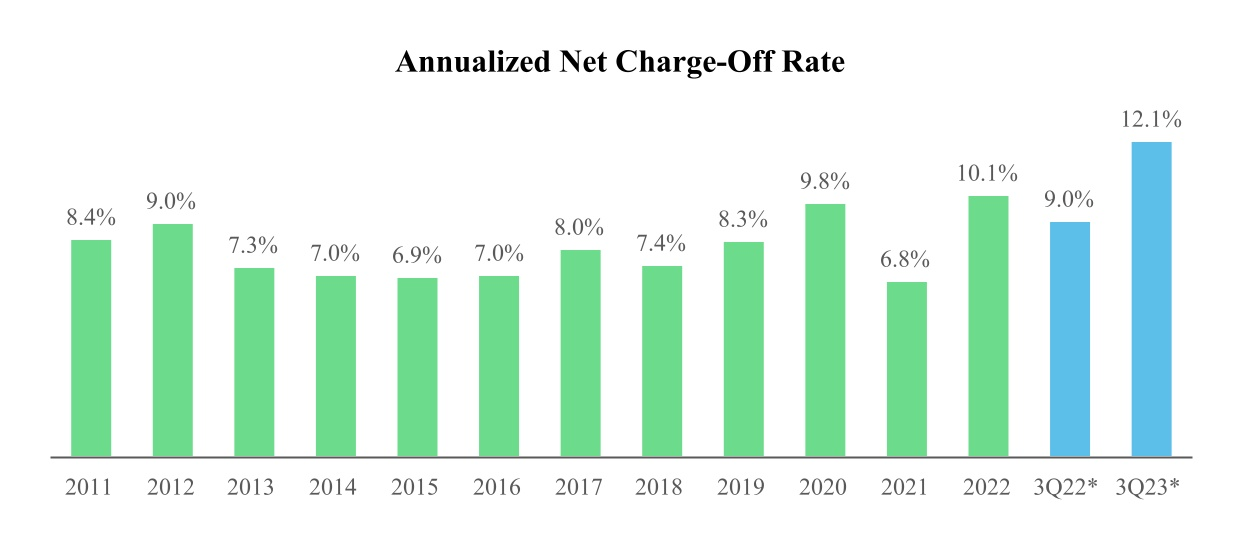

In [1]:
from PIL import Image

# Image source: https://investor.oportun.com/sec-filings/all-sec-filings/content/0001538716-23-000178/oprt-20230930_g1.jpg
image = Image.open("./data/plot.jpg").convert("RGB")
display(image)

## Step 3: Plot-to-text generation

In [17]:
inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")
inputs = inputs.to("cuda")

predictions = deplot.generate(**inputs, max_new_tokens=512)
plot = processor.decode(predictions[0], skip_special_tokens=True)
plot = plot.replace("<0x0A>", "\n") # Deplot's tokenizer represents newline as <0x0A>

print(plot)

TITLE | Annualized Net Charge-Off Rate
Year | Annualized Net Charge-Off Rate
2011 | 8.4%
2012 | 9.0%
2013 | 7.3%
2014 | 7.0%
2015 | 6.9%
2016 | 7.0%
2017 | 8.0%
2018 | 7.4%
2019 | 8.3%
2020 | 9.8%
2021 | 6.8%
2022 | 10.1%
3Q22* | 9.0%
3Q23* | 12.1%


## Step 4: Plot reasoning

In [28]:
input_text = "What is the trend of the net charge-off rate?\n" + plot
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

outputs = gemma.generate(**inputs, max_new_tokens=512)
print(tokenizer.decode(outputs[0][len(inputs.input_ids[0]):], skip_special_tokens=True))



What is the trend of the net charge-off rate?

The net charge-off rate has been steadily increasing since 2011, reaching a high of 10.1% in 2022. The trend suggests that the rate is likely to continue increasing in the future.
